# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

# Содержание

### [Шаг 1. Знакомство с данными](#section1)  

### [Шаг 2. Предобработка данных](#section2)  
#### - [2.1. Обработка выбросов:](#section2.1)  
  - [2.1.1. Высота потолков](#section2.1.1)  
  - [2.1.2. Стоимость](#section2.1.2)  
  - [2.1.3. Общая площадь](#section2.1.3)
  
#### - [2.2. Заполнение пропусков:](#section2.2)  
  - [2.2.1. Стратегия заполнения пропусков](#section2.2.1)
  - [2.2.2. Пропущенные значения этажности](#section2.2.2)
  - [2.2.3. Пропущенные значения высоты потолков](#section2.2.3) 
  - [2.2.4. Оставшиеся пропущенные значения](#section2.2.4) 
  - [2.2.5. Обработка столбца с временем](#section2.2.5)
  - [2.2.6. Преобразуем типы данных](#section2.2.6)  
  - [2.2.7. Квартиры с нулевым значением комнат](#section2.2.7)  
  - [Вывод](#section2.2.8)  
  
### [Шаг 3. Feature engeneering](#section3)  
 - [3.1. Добавим цену за кв. метр. в таблицу](#section3.1)  
 - [3.2. Добавим столбцы с днем недели, месяцем и годом](#section3.2)  
 - [3.3. Столбец с этажом: первый, последний, другой](#section3.3)  
 - [3.4. Добавим отношение жилой площади к общей](#section3.4) 
 - [3.5. Добавим отношение площади кухни к общей](#section3.5)  
 
### [Шаг 4. Исследовательский анализ данных](#section4)  
 - [4.1.  Гистограммы распределения *Общей площади*, *Цены*, *Комнат*, *Высоты потолков*](#section4.1)  
 - [4.2.  Распределение времени продаж](#section4.2)  
 - [4.3.  Как стоимость квартиры зависит от *площади*, *числа комнат*, *удалённости от центра*](#section4.3)  
 - [4.4.  Зависимость стоимости квартиры от этажа](#section4.4)  
 - [4.5.  Зависимость стоимости квартиры от даты размещения: *дня недели*, *месяца и года*.](#section4.5)  
 - [4.6.  10 населенных пунктов с самой высокой стоимостью кв. метра](#section4.6)  
 - [4.7.  Стоимость квартир в центре](#section4.7)  
 - [4.8.  Проанализируем квартиры в центре](#section4.8)  
 - [4.9.  Влияние факторов на стоимость квартиры в центре (*число комнат, этаж, удалённость от центра, дата размещения объявления*)](#section4.9)
 - [4.10. Зависимость от *даты*](#section4.10)  

### [Шаг 5. Общий вывод](#section5)  

<a id='section1'></a>

# Шаг 1. Откройте файл с данными и изучите общую информацию. 

___

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [3]:
df = pd.DataFrame(data.copy(deep=True))

In [4]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

>###### В датафрейме имеются столбцы различных типов данных, имеются строковые, например *first_day_exposition* - его мы переведем в формат даты на этапе предобработки.  
>###### Много столбцов типа float, некоторые из них для удобства можно будет перевести в int.   
>###### Имеются пропуски, рассмотрим их количество ниже

In [6]:
#количество пропусков
df.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

### **_<span style="color:blue">Проверим количество дубликатов</span>_**

In [7]:
print("Количество дубликатов:", df.duplicated().sum())

Количество дубликатов: 0


### Вывод

>###### Датасет содержит 22 столбца и 23699 строк, во многих строках имеются множественные пропуски, которые придется заполнять разными методами. Некоторые будем заполнять нулями или False, количественные - медианами, а некоторые данные, возможно, получится достать из уже имеющихся.  
>###### Датасет также содержит различные типы данных, которые мы также преобразуем на втором шаге - предобработка данных. Дубликатов в данных нет.

<a id='section2'></a>

# Шаг 2. Предобработка данных

___

<a id='section2.1'></a>

## 2.1. Обработка выбросов

<a id='section2.1.1'></a>

### 2.1.1 Рассмотрим высоту потолков

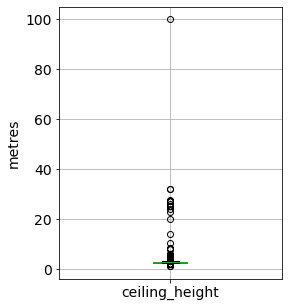

In [8]:
df.boxplot(["ceiling_height"], figsize=(4,5), fontsize=14)
plt.ylabel("metres", fontsize=14)
plt.show()

In [9]:
df[df.ceiling_height > 20].head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3600000.0,55.2,2018-07-12T00:00:00,2,25.0,5.0,32.0,2,False,...,NaN,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
3148,14,2900000.0,75.0,2018-11-12T00:00:00,3,32.0,3.0,53.0,2,NaN,...,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4643,0,4300000.0,45.0,2018-02-01T00:00:00,2,25.0,9.0,30.0,2,NaN,...,7.0,1.0,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0


Складывается впечатление, что эти значения являются ошибкой при наборе с клавиатуры и истинное значение меньше на порядок. Единственный выброс - 100метровый потолок, не известно, что это, поэтому имеет смысл избавиться от этого наблюдения. Хотя выбросов и не так много, можно было бы и просто исключить их из наших данных, но я предпочту их оставить и поделить значения столбца высоты потолков на 10.

In [10]:
df = df.drop([22869]) #удаляем 100метровые потолки

In [11]:
df['ceiling_height'] = df['ceiling_height'].apply( lambda x: x if (x < 20) else x/10 ) # делим значения потолков, которые больше 20 на 10

#### Дропнем строки с аномально высокими и низкими потолками

In [12]:
df.drop(df[df.ceiling_height > 3.5].index, inplace=True)
df.drop(df[df.ceiling_height < 2.001].index, inplace=True)

##### Проверим как выглядит boxplot теперь

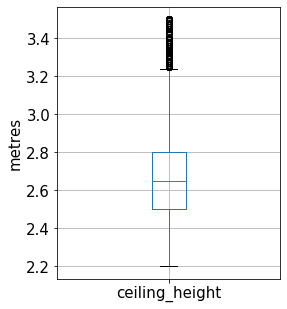

In [13]:
df.boxplot(['ceiling_height'], figsize=(4,5), fontsize=15)
plt.ylabel("metres", fontsize=15)
plt.show()

In [14]:
df.reset_index(inplace=True) #Дадим новые индексы

In [15]:
df.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [16]:
df.drop(labels='index', axis=1, inplace=True)

In [17]:
print("Среднее по высоте потолков: {:.2f}".format(df.ceiling_height.mean()))
print("Медиана по высоте потолков: {:.2f}".format(df.ceiling_height.median()))

Среднее по высоте потолков: 2.70
Медиана по высоте потолков: 2.65


<a id='section2.1.2'></a>

##  2.1.2. Стоимость закрытия

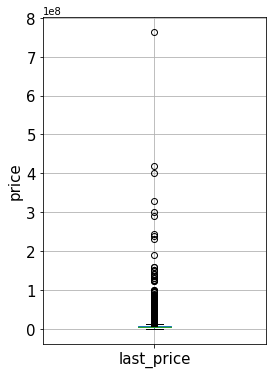

In [18]:
df.boxplot(['last_price'], figsize=(4,6), fontsize=15)
plt.ylabel("price", fontsize=15)
plt.show()

In [19]:
print("Медианная стоимость квартиры : {:.0f}".format(df['last_price'].median()))
print("Средняя стоимость квартиры : {:.0f}".format(df['last_price'].mean()))
print("Количество квартир стоимостью более 20 млн. : {}".format(df[df.last_price > 20000000]['last_price'].count()))
print("Количество квартир стоимостью менее 500 тыс. : {}".format(df[df.last_price < 500000]['last_price'].count()))

Медианная стоимость квартиры : 4600000
Средняя стоимость квартиры : 6355715
Количество квартир стоимостью более 20 млн. : 639
Количество квартир стоимостью менее 500 тыс. : 14


###### В нашей выборке очень мало квартир стоимостью больше 20 млн. и дешевле 500 тыс. Избавимся от этих аномальных наблюдений

In [20]:
df.drop(df[df.last_price > 20000000].index, inplace=True)
df.drop(df[df.last_price < 500000].index, inplace=True)

<a id='section2.1.3'></a>

##  2.1.3 Общая площадь

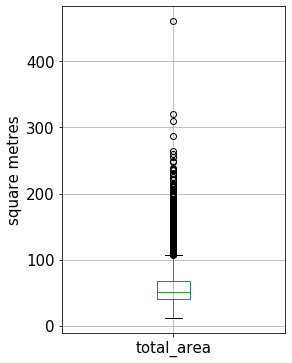

In [21]:
df.boxplot(['total_area'], figsize=(4,6), fontsize=15)
plt.ylabel("square metres", fontsize=15)
plt.show()

In [22]:
print("Медианная площадь квартиры : {:.0f}".format(df['total_area'].median()))
print("Средняя площадь квартиры : {:.0f}".format(df['total_area'].mean()))
print("Количество квартир площадью более 120 кв. м. : {}".format(df[df.total_area > 120]['total_area'].count()))
print("Количество квартир площадью менее 15 кв.м. : {}".format(df[df.total_area < 15]['total_area'].count()))

Медианная площадь квартиры : 51
Средняя площадь квартиры : 56
Количество квартир площадью более 120 кв. м. : 483
Количество квартир площадью менее 15 кв.м. : 6


###### Избавимся от аномальных значений

In [23]:
df.drop(df[df.total_area > 120].index, inplace=True)
df.drop(df[df.total_area < 15].index, inplace=True)

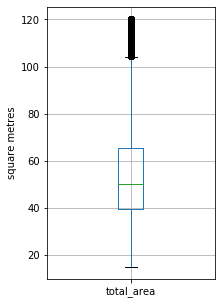

In [99]:
df.boxplot(['total_area'], figsize=(3,5), fontsize=10)
plt.ylabel("square metres", fontsize=10)
plt.show()

<a id='section2.2'></a>

## 2.2. Заполнение пропусков

___

### Пропуски в столбцах:

In [27]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           8788
floors_total               82
living_area              1744
floor                       0
is_apartment            19675
studio                      0
open_plan                   0
kitchen_area             2135
balcony                 10688
locality_name              44
airports_nearest         5463
cityCenters_nearest      5446
parks_around3000         5445
parks_nearest           15122
ponds_around3000         5445
ponds_nearest           14100
days_exposition          2818
dtype: int64

<a id='section2.2.1'></a>

### 2.2.1 Стратегия заполнения пропусков
- `floors_total`  -  по возможности заполним пропуски уже имеющимися данными по тому же дому из датасета (предположим, что каждый дом однозначно определяется расстоянием до аэропорта и центра города), оставшиеся пропуски заполним медианными значениями  
- `ceiling_height` -  попробуем определить высоту потолков по существующим домам, оставшиеся пропуски оставим незаполненными
- `living_area`  ,  `kitchen_area`  -  заполним медианой  
- `is_apartment`  -  заполним пропуски значениями False  
- `balcony`  -  пропущенные значения заменим на 0  
- `locality_name`  -  на пустую строку " "  
- `airports_nearest`  ,  `cityCenters_nearest`  ,  `parks_nearest`  ,  `ponds_nearest`  ,   `days_exposition` -  оставим пропущенные значения как они есть, чтобы не исказить статистики и в будущем иметь возможность работать с ними как с числовыми столбцами. Заполнять пропуски в данных столбцах не будем  
- `ponds_around3000`  ,  `parks_around3000`  -  заполним нулями

<a id='section2.2.2'></a>

### 2.2.2 Заполним пропущенные значения этажности

In [30]:
print("Пропущенных значений этажности дома:", df.floors_total.isna().sum())

Пропущенных значений этажности дома: 82


#### Создадим для этого сводную таблицу, где индексами будет выступать `расстояние до центра`, а столбцами - `расстояния до аэропорта`

In [31]:
floors_pivot = df.pivot_table(index='cityCenters_nearest', columns='airports_nearest', values='floors_total', aggfunc='first')

###### Используем цикл, пробегающий по датафрейму, в котором пропущены значения `этажности` дома

In [32]:
for index, row in df[df.ceiling_height.isna()].iterrows() :
    
    try:
        cell = floors_pivot.loc[ (row['cityCenters_nearest']) , (row['airports_nearest']) ]
        
        if not(pd.isnull(cell)):                       # Проверяем не равно ли NaN значение ячейки в pivot_table
            df.loc[index, 'floors_total'] = cell       # Заменяем пропущенное значение этажности в нашем df на значение из pivot
    
    except:
        pass # В случае если такого дома не существует
print("Пропусков:", df.floors_total.isna().sum())

Пропусков: 30


###### Оставшиеся 33 пропуска этажности заполним медианными значениями, не получилось заменить те значения, где нет подобного сочетания расстояний, т.е. дом не существует. Большую часть значений удалось заменить, значит многие дома встречаются как минимум дважды

In [33]:
df.floors_total.fillna(value=df['floors_total'].median(), inplace=True)

In [34]:
print("Пропусков этажности:", df.floors_total.isna().sum())

Пропусков этажности: 0


<a id='section2.2.3'></a>

### 2.2.3 Заполним пропущенные значения  `высоты потолков`

In [35]:
ceilings_pivot = df.pivot_table(index='cityCenters_nearest', columns='airports_nearest', values='ceiling_height', aggfunc='first')

In [36]:
for index, row in df[df.ceiling_height.isna()].iterrows() :
    
    try:
        cell = ceilings_pivot.loc[ (row['cityCenters_nearest']) , (row['airports_nearest']) ]
        
        if not(pd.isnull(cell)):                       # Проверяем не равно ли NaN значение ячейки в pivot_table
            df.loc[index, 'ceiling_height'] = cell       # Заменяем пропущенное значение этажности в нашем df на значение из pivot
    
    except:
        pass # В случае если такого дома не существует
print("Количество пропусков в столбце высоты потолков:", df.ceiling_height.isna().sum())
print(f"Таким способом нам удалось устранить {9150 - df.ceiling_height.isna().sum()} пропуска точно правильными значениями" )

Количество пропусков в столбце высоты потолков: 5328
Таким способом нам удалось устранить 3822 пропуска точно правильными значениями


<a id='section2.2.4'></a>

### 2.2.4. Заполним оставшиеся пропуски

In [37]:
df.fillna( 
    value =     
                {
                 'living_area' : df['living_area'].median(),   # Заполним пропуски в столбце жилой и кухонной
                 'kitchen_area' : df['kitchen_area'].median(), # площади на медианное значение
                 'is_apartment' : False,                       # Заполним пропуски на False в столбце is_apartment
                 'balcony' : 0,                             
                 'parks_around3000' : 0,
                 'ponds_around3000' : 0,
                 'locality_name' : " ",                        # Заполним пропущенные значения locality_name на пустую строку
                 }, 
          
                  inplace=True )

<a id='section2.2.5'></a>

### 2.2.5. Обработаем столбец с `временем`

In [38]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [39]:
df.first_day_exposition.head(3)

0   2019-03-07
1   2018-12-04
2   2015-08-20
Name: first_day_exposition, dtype: datetime64[ns]

<a id='section2.2.6'></a>

### 2.2.6 Преобразуем типы данных

In [40]:
df['last_price'] = df['last_price'].astype(int)
df['floors_total'] = df.floors_total.astype(int)
df['balcony'] = df['balcony'].astype(int)

In [41]:
#df[(df.rooms == 0) & (df.studio == False)]['total_area'].value_counts().sort_index().tail(10)
# Рассмотрим квартиры с нулевым количество комнат и не студии

In [100]:
#Скорее всего это пропуски при заполнении данных, заменим количество комнат для квартир площадью менее 45 кв.м. на 1, для тех у которых меньше 100 кв.м. на 2, для остальных - на 5 

<a id='section2.2.7'></a>

## 2.2.7. Расмотрим квартиры с нулевым значением комнат и не являющиеся студиями: 

In [42]:
df[(df.rooms == 0) & (df.studio == False)]['total_area'].value_counts().sum()

58

Дропнем эти строки

In [43]:
df.drop(df[(df.rooms == 0) & (df.studio == False)].index, inplace=True)

<a id='section2.2.8'></a>

# Вывод

>На данном этапе мы очистили данные от выбросов.  
Произвели различные замены пропущенных значений.  
Для многих квартир отсутствовали значения `total_floors` или `ceiling_height` - многие из них нам удалось восстановить из имеющихся данных, поскольку дома в датасете повторяются.  
Некоторые пропущенные значения оставили незаполненными для того, чтобы избежать искажения статистики, а также с NaN удобно проводить вычисления, так как это тип float  
Количественные параметры: `living_area` , `kitchen_area` были заменены на медианные.  
Также преобразованы типы данных: из строковых в формат даты, из чисел с плавающей точкой в целочисленный.  
Квартиры с нулевым количеством комнат были удалены из датафрейма.

<a id='section3'></a>

## Шаг 3. Посчитайте и добавьте в таблицу

___

<a id='section3.1'></a>

### 3.1. Добавим цену за кв. метр. в таблицу

In [44]:
df['price_for_square_meter'] = df['last_price'] / df['total_area']

<a id='section3.2'></a>

### 3.2. Добавим столбцы с днем недели, месяцем и годом

In [45]:
df['weekday'] = df['first_day_exposition'].dt.weekday

In [46]:
df['month'] = df['first_day_exposition'].dt.month

In [47]:
df['year'] = df['first_day_exposition'].dt.year

<a id='section3.3'></a>

### 3.3. Столбец с этажом: первый, последний, другой

In [48]:
def flat_floor(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

In [49]:
df['floor_category'] = df.apply(flat_floor, axis=1)

In [50]:
df.floor_category.value_counts() 

другой       16384
последний     3020
первый        2798
Name: floor_category, dtype: int64

Первых и последних этажей примерно одинаковое количество

<a id='section3.4'></a>

### 3.4. Добавим отношение жилой площади к общей

In [51]:
df['living_to_total'] = df.living_area / df.total_area

<a id='section3.5'></a>

### 3.5. Добавим отношение площади кухни к общей

In [52]:
df['kitchen_to_total'] = df.kitchen_area / df.total_area

<a id='section4'></a>

## Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

___

<a id='section4.1'></a>

### 4.1 Построим гистограммы распределения  `Общей площади`  ,  `Цены`  ,  `Комнат`  ,  `Высоты потолков`

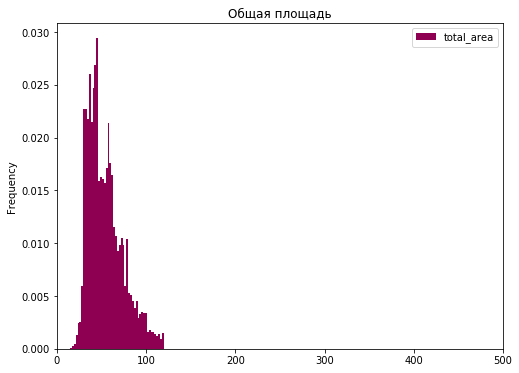

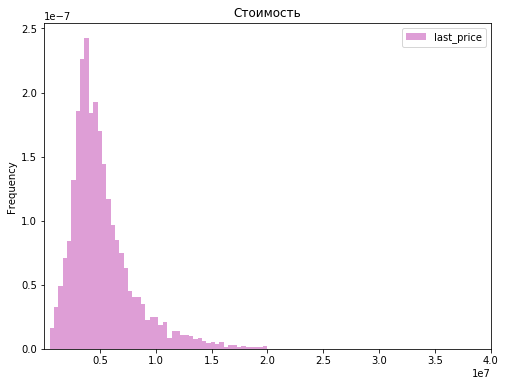

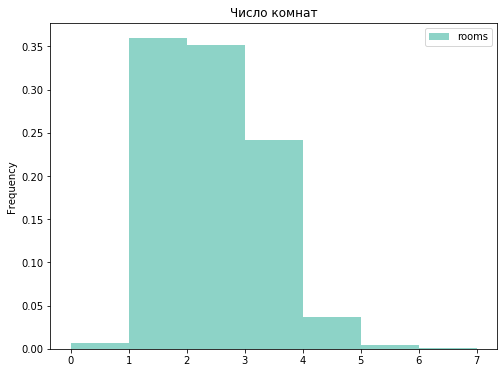

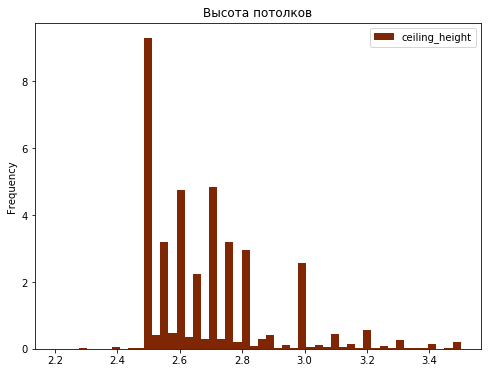

In [103]:
df.plot(y='total_area', kind='hist', density=True, bins=50, xlim=(0,500), figsize=(8,6), title='Общая площадь', colormap='PiYG')
df.plot(y='last_price', kind='hist', density=True, bins=50, xlim=(12190,40000000.0), figsize=(8,6), title='Стоимость', colormap='tab20b_r')
df.plot(y='rooms', kind='hist', density=True, bins=7, range=(0, 7), figsize=(8,6), title='Число комнат', colormap='Set3')
df.plot(y='ceiling_height', kind='hist', bins=50, range=(2.2, 3.5), density=True, figsize=(8,6), title='Высота потолков', colormap='Oranges_r')
plt.show()

In [54]:
print("Медианное значение площади:", df.total_area.median() )

Медианное значение площади: 50.1


In [55]:
print("Медианное значение цены:", df.last_price.median() )

Медианное значение цены: 4500000.0


In [56]:
print("Медианное значение высоты потолков:", df.ceiling_height.median() )

Медианное значение высоты потолков: 2.65


### Вывод

>Медианное значение площади - 50 кв.м., распределение имеет вид Пуассоновского с пиком около 40 кв.м.  
Медианная стоимость квартиры составляет 4.5 млн.  
Наибольшее количество квартир однокомнатные, хотя двухкомнатных всего лишь немногим меньше.  
Высота потолков составляет 2.65 метра.

<a id='section4.2'></a>

### 4.2 Рассмотрим распределение времени продаж

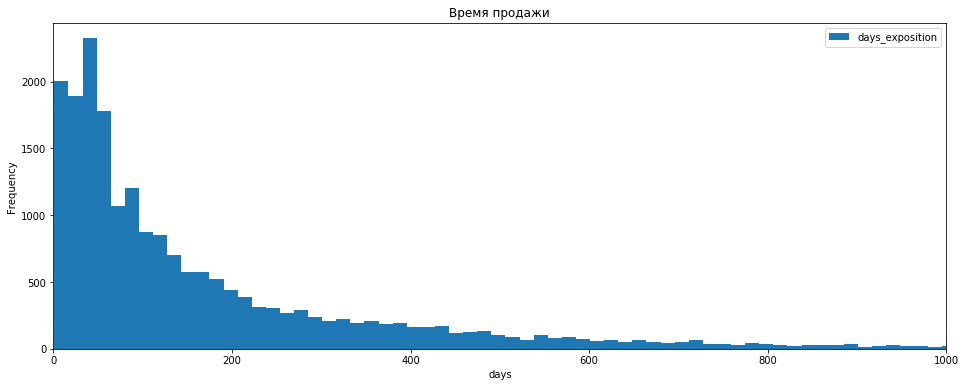

In [57]:
data.plot(y='days_exposition', kind='hist', bins=100, figsize=(16,6), xlim=(0,1000), title='Время продажи')
plt.xlabel("days")
plt.show()

In [58]:
print("Медианное значение времени, требующееся на продажу квартиры: {:.0f}".format(df.days_exposition.median() ))
print("Среднее значение времени на продажу квартиры: {:.1f}".format(df.days_exposition.mean() ))

Медианное значение времени, требующееся на продажу квартиры: 93
Среднее значение времени на продажу квартиры: 175.3


#### Медианное значение времени продажи квартиры составляет 95 дней, среднее - 180 , что говорит о наличии сильных выбросов

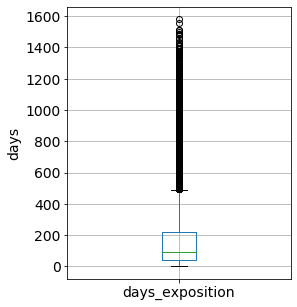

In [59]:
df.boxplot(["days_exposition"], figsize=(4,5), fontsize=14)
plt.ylabel("days", fontsize=14)
plt.show()

#### Избавимся от аномальных значений. Будем считать продажу быстрой, если она уложилась в неделю, и медленной, если она длилась более полутора лет

In [60]:
good_exposition_data = data.query('7<days_exposition<550')['days_exposition'] # избавляемся от выбросов и аномальных 
                                                                              # по скорости продаж
good_exposition_data = good_exposition_data.astype(int)

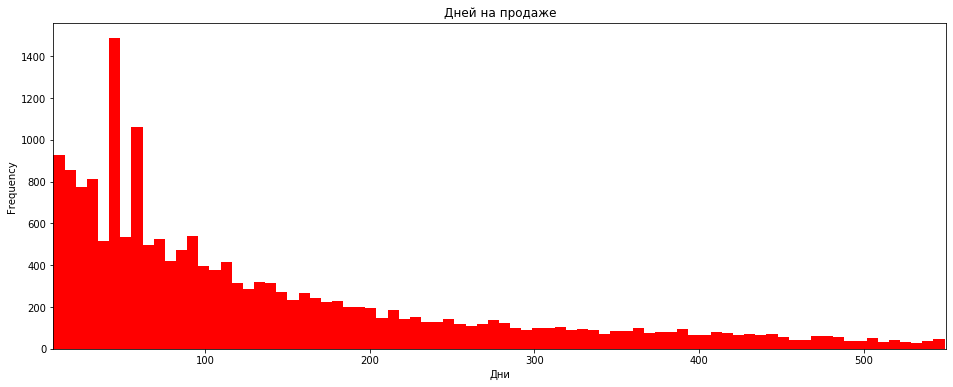

In [106]:
good_exposition_data.plot(kind='hist', bins=80, xlim=(8,550), figsize=(16,6), colormap='bwr_r')
plt.xlabel("Дни")
plt.title("Дней на продаже")
plt.show()

In [107]:
good_exposition_data.value_counts().head(4)

45    880
60    538
30    208
90    204
Name: days_exposition, dtype: int64

#### Значения 45, 60, 30, 90 - самые популярные и явно отличаются от других в большую сторону

In [63]:
print(f"Мединное значение времени продажи - порядка {good_exposition_data.median()} дней")

Мединное значение времени продажи - порядка 91.0 дней


<a id='section4.3'></a>

### 4.3 Посмотрим, как стоимость `Квартиры` зависит от `площади` ,  `числа комнат`  ,  `удалённости от центра`.

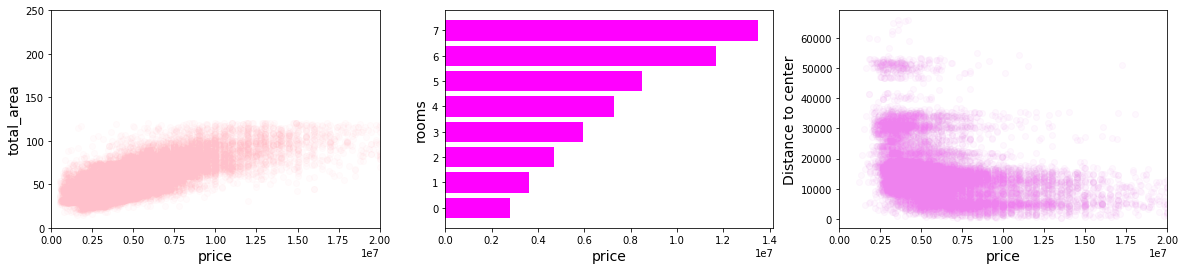

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))

ax1.scatter(df['last_price'], df['total_area'], c='pink', alpha=0.05)
ax1.set_xlim([0,20000000])
ax1.set_ylim([0,250])
ax1.set_ylabel('total_area', fontsize=14)
ax1.set_xlabel('price', fontsize=14)

rooms_price = df[['rooms', 'last_price']].groupby(['rooms']).median()
ax2.barh( rooms_price.index, rooms_price['last_price'], color='magenta' )
ax2.set_ylabel('rooms', fontsize=14)
ax2.set_xlabel('price', fontsize=14)
y_pos = np.arange(0,8)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([str(i) for i in range(0,8)])

ax3.scatter(df['last_price'], df['cityCenters_nearest'], c='violet', alpha=0.05)
ax3.set_xlim([0,20000000])
ax3.set_ylabel('Distance to center', fontsize=14)
ax3.set_xlabel('price', fontsize=14)

plt.show()

In [65]:
df[['last_price','total_area','cityCenters_nearest','rooms']].corr()

,last_price,total_area,cityCenters_nearest,rooms
last_price,1.000000,0.735474,-0.346756,0.439876
total_area,0.735474,1.000000,-0.171292,0.793398
cityCenters_nearest,-0.346756,-0.171292,1.000000,-0.103201
rooms,0.439876,0.793398,-0.103201,1.000000


#### На графике зависимости стоимости квартиры от общей площади явно видна положительная корреляция.
#### На столбчатой диаграмме также заметна увеличивающаяся стоимость квартиры с увеличением числа комнат.
#### На графике зависимости стоимости квартиры от расстояния до центра города также видна зависимость, предположительно - гиперболическая. Чем дальше квартира - тем дешевле она стоит

<a id='section4.4'></a>

### 4.4 Рассмотрим как зависит стоимость квартиры от этажа

In [66]:
floor_price = df[['floor_category', 'last_price']].groupby(['floor_category']).median().sort_values('last_price')

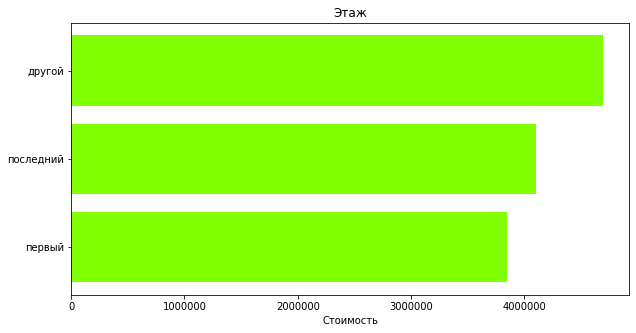

In [67]:
plt.figure(figsize=(10,5))
plt.barh( floor_price.index, floor_price['last_price'], color='chartreuse' )
plt.title("Этаж")
plt.xlabel("Стоимость")
plt.show()

#### Квартиры на первом этаже, как правило, дешевле других. Квартиры на последнем также стоят дешевле.

<a id='section4.5'></a>

### 4.5. Рассмотрим как зависит стоимость квартиры от даты размещения: дня недели, месяца и года.

### Год

In [68]:
year_price = df[['year', 'last_price']].groupby(['year']).median().sort_index()

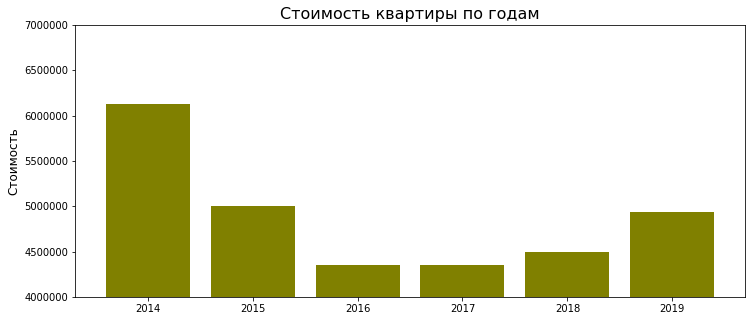

In [109]:
plt.figure(figsize=(12,5))
plt.bar( year_price.index, year_price['last_price'], color='olive' )
plt.title("Стоимость квартиры по годам", fontsize=16)
plt.ylabel("Стоимость", fontsize=12)
plt.ylim(4000000, 7000000)
plt.show()

>#### С 2014 года стоимость квартир сильно упала, однако с 2017 тренд меняется на растущий

### Месяц

In [70]:
month_price = df[['month', 'last_price']].groupby(['month']).median().sort_index()
month_price.index = ['январь', 'февраль', 'март', "апрель", "май", "июнь", "июль", "август", "сентябрь", "октябрь", "ноябрь", "декабрь"]

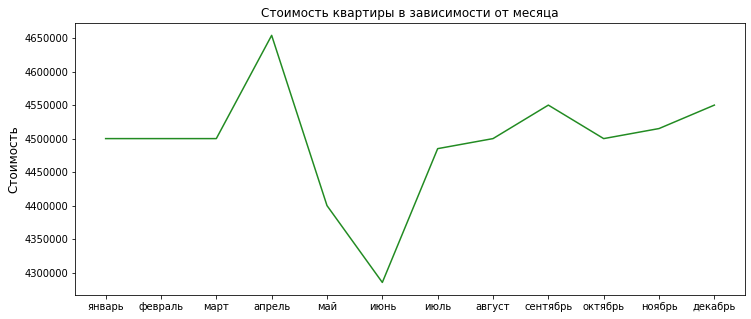

In [71]:
plt.figure(figsize=(12,5))
plt.plot( month_price.index, month_price['last_price'], color='forestgreen' )
plt.title("Стоимость квартиры в зависимости от месяца")
plt.ylabel("Стоимость", fontsize=12)
plt.show()

>#### В **июне** квартиры продаются дешевле, чем в остальные месяцы
>#### Пик стоимости приходится на **апрель**

### День

In [72]:
day_price = df[['weekday', 'last_price']].groupby(['weekday']).median().sort_index()
day_price.index = ["понедельник", "вторник", "среда", "четверг", "пятница", "суббота", "воскресенье"]

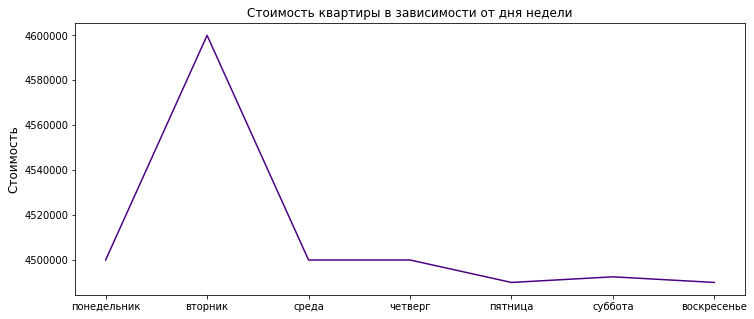

In [73]:
plt.figure(figsize=(12,5))
plt.plot( day_price.index, day_price['last_price'], color="indigo" )
plt.ylabel("Стоимость", fontsize=12)
plt.title("Стоимость квартиры в зависимости от дня недели")
plt.show()

>####  В __воскресенье__ квартиры продаются дешевле, чем в остальные дни 
>####  А по **вторникам** цена обычно выше 

<a id='section4.6'></a>

### 4.6. 10 населенных пунктов с самой высокой стоимостью кв. метра

In [74]:
top_locals = df.groupby('locality_name')['locality_name'].count().sort_values(ascending=False).head(10).index.values.tolist()

In [75]:
df_filtered = df.query('locality_name in @top_locals')

In [76]:
df_filtered.groupby('locality_name')['price_for_square_meter'].mean().sort_values(ascending=False)

locality_name
Санкт-Петербург      108645.684395
Пушкин               101913.956187
деревня Кудрово       92312.310411
посёлок Парголово     90348.996281
посёлок Мурино        85563.326907
посёлок Шушары        78643.827638
Колпино               75370.025473
Гатчина               68974.051834
Всеволожск            67173.646003
Выборг                58336.368985
Name: price_for_square_meter, dtype: float64

>#### Самые дорогие квартиры располагаются, ожидаемо, в Санкт-Петербурге (115 тыс.), затем идет Пушкин.  
>#### Низкая стоимость квартир в Выборге - в два раза дешевле, чем в Санкт-Петербурге.    
>#### Во Всеволожске и Гатчине примерно одинаковые цены за кв.м., порядка 68 тыс.

<a id='section4.7'></a>

### 4.7. Стоимость квартир в центре

In [77]:
df['kilometres_to_cityCenters'] =( df['cityCenters_nearest']/1000 ).round()

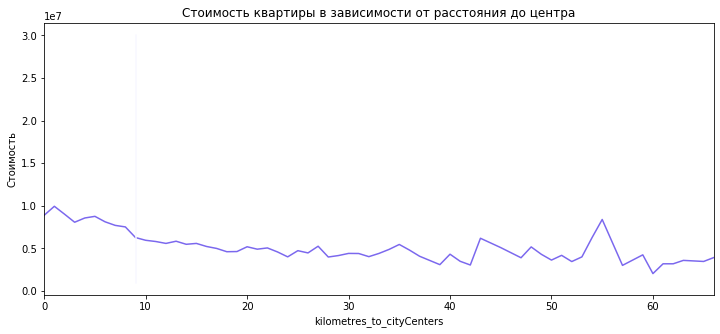

In [78]:
plt.figure(figsize=(12,5))
df.groupby('kilometres_to_cityCenters')['last_price'].mean().plot(color='mediumslateblue')
plt.plot([9,9],[1000000,30000000], color='ghostwhite')
plt.title("Стоимость квартиры в зависимости от расстояния до центра")
plt.ylabel("Стоимость")
plt.show()

>#### На графике видно, что цена сильно меняется на 8-9 километрах, следовательно это и есть граница центра города

<a id='section4.8'></a>

### 4.8. Проанализируем квартиры в центре

In [79]:
df_flats_in_center = df.query('kilometres_to_cityCenters <= 8 and locality_name == "Санкт-Петербург"')

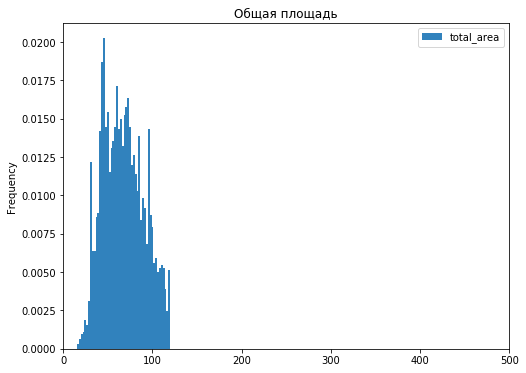

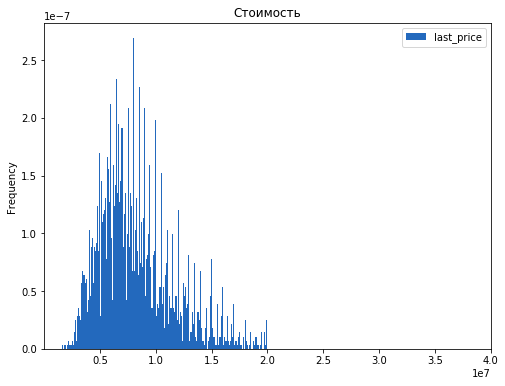

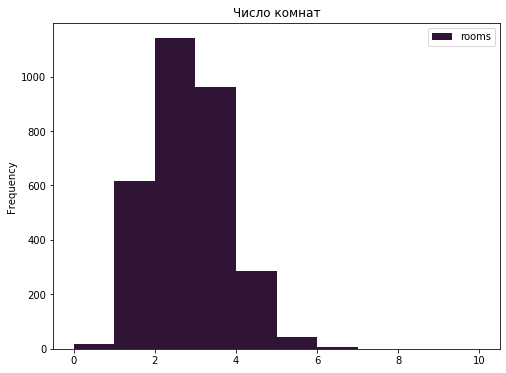

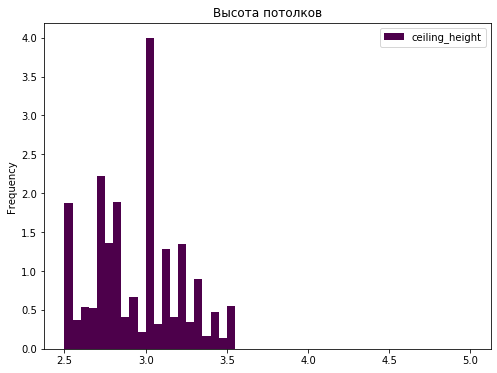

In [80]:
df_flats_in_center.plot(y='total_area', kind='hist', density=True, bins=50, xlim=(0,500), figsize=(8,6), title='Общая площадь', colormap="tab20c")
df_flats_in_center.plot(y='last_price', kind='hist', density=True, bins=200, xlim=(12190,40000000.0), figsize=(8,6), title='Стоимость', colormap="vlag")
df_flats_in_center.plot(y='rooms', kind='hist', bins=10, range=(0, 10), figsize=(8,6), title='Число комнат', colormap="twilight_shifted_r")
df_flats_in_center.plot(y='ceiling_height', kind='hist', bins=50, range=(2.5, 5), density=True, figsize=(8,6), title='Высота потолков', colormap="BuPu_r")
plt.show()

In [81]:
print("Медианное значение площади", df_flats_in_center['total_area'].median() )

Медианное значение площади 66.5


In [82]:
print("Медианное значение цены", df_flats_in_center['last_price'].median() )

Медианное значение цены 7700000.0


In [83]:
print("Медианное значение высоты потолков", df_flats_in_center.ceiling_height.median() )

Медианное значение высоты потолков 2.95


>##### Квартиры в центре города могут "похвастать" большей площадью - 66 кв.м.  
>##### Такие квартиры также в среднем более дорогие, медианная стоимость составляет почти 8 млн. В то время, как для всех квартир эта стоимость равняется 4,5 миллионам.  
>##### Квартиры в центре также чаще двух- или трехкомнатные, тогда как в общей массе больше "однушек".   
>##### У данных квартир также выше потолки, в среднем - 3 метра.

<a id='section4.9'></a>

### 4.9.  Выясним какие факторы влияют на стоимость квартиры  в центре (`число комнат`, `этаж`, `удалённость от центра`, `дата размещения объявления`) и сравним с выводом по всем квартирам

### Число комнат

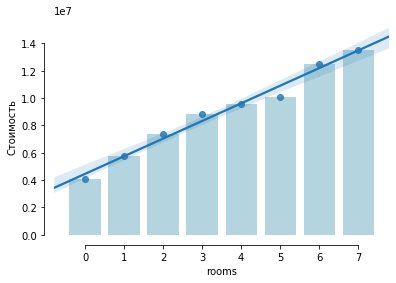

In [84]:
rooms_price_center = df_flats_in_center[['rooms', 'last_price']].groupby(['rooms']).median()
ax = sns.barplot(x=rooms_price_center.index, y=rooms_price_center['last_price'] , color='lightblue' )
# put bars in background:
for c in ax.patches:
    c.set_zorder(0)
# plot regplot with numbers 0,..,len(a) as x value
sns.regplot(x=np.arange(0,len(rooms_price_center)), y=rooms_price_center['last_price'], ax=ax)
sns.despine(offset=10, trim=True)
ax.set_ylabel("Стоимость")
plt.show()

>#### Стоимость квартиры также увеличивается в зависимости от количества комнат, как и во всем датасете

### Этаж

In [85]:
floor_price_center = ( df_flats_in_center[['floor_category', 'last_price']].groupby('floor_category').median()
                      .sort_values('last_price') )

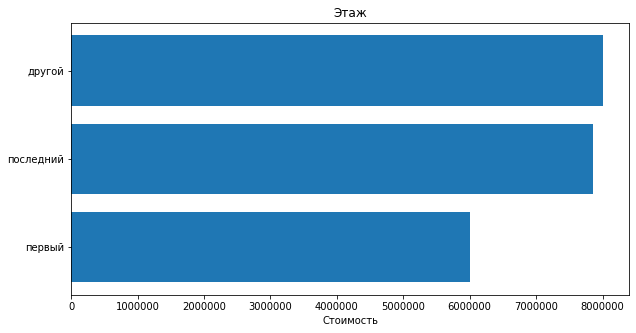

In [86]:
plt.figure(figsize=(10,5))
plt.barh( floor_price_center.index, floor_price_center['last_price'] )
plt.title("Этаж")
plt.xlabel("Стоимость")
plt.show()

>#### Квартиры на первом этаже в центре Санкт-Петербурга также дешевле.

### Удаленность

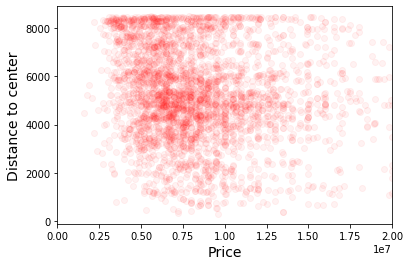

In [87]:
plt.scatter(df_flats_in_center['last_price'], df_flats_in_center['cityCenters_nearest'], c='r', alpha=0.05)
plt.xlim(0,20000000)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Distance to center', fontsize=14)
plt.show()

In [88]:
df_flats_in_center[['last_price', 'cityCenters_nearest']].corr()

,last_price,cityCenters_nearest
last_price,1.000000,-0.141776
cityCenters_nearest,-0.141776,1.000000


>#### А вот зависимости от удаленности нет, квартиры могут стоить в центре по разному.

<a id='section4.10'></a>

### 4.10. Посмотрим зависимость от даты

### Год

In [89]:
year_price_center = df_flats_in_center[['year', 'last_price']].groupby(['year']).median().sort_index()

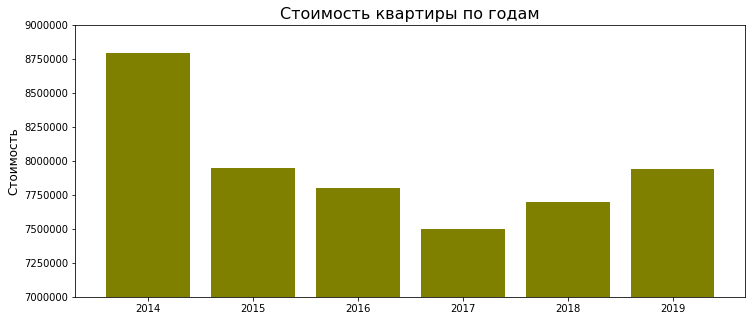

In [90]:
plt.figure(figsize=(12,5))
plt.bar( year_price_center.index, year_price_center['last_price'], color='olive' )
plt.title("Стоимость квартиры по годам", fontsize=16)
plt.ylabel("Стоимость", fontsize=12)
plt.ylim(7000000,9000000)
plt.show()

>#### Диаграмма точно такая же, как и для всей выборки, с 2014 стоимость упала, а c 2017 начинает расти

### Месяц

In [91]:
month_price_center = df_flats_in_center[['month', 'last_price']].groupby(['month']).median().sort_index()
month_price_center.index = ['январь', 'февраль', 'март', "апрель", "май", "июнь", "июль", "август", "сентябрь", "октябрь", "ноябрь", "декабрь"]

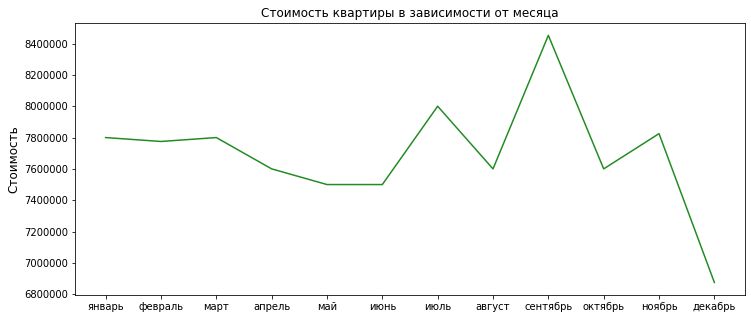

In [92]:
plt.figure(figsize=(12,5))
plt.plot( month_price_center.index, month_price_center['last_price'], color='forestgreen' )
plt.title("Стоимость квартиры в зависимости от месяца")
plt.ylabel("Стоимость", fontsize=12)
plt.show()

>#### Для квартир в центре Санкт-Петербурга картина меняется: наименьшая стоимость соответствует квартирам, продаваемым в декабре.  
>#### А наибольшая стоимость в сентябре, вероятно, все хотят купить квартиру поближе к работе перед началом учебного/рабочего года

### День

In [93]:
day_price_center = df_flats_in_center[['weekday', 'last_price']].groupby(['weekday']).median().sort_index()
day_price_center.index = ["понедельник", "вторник", "среда", "четверг", "пятница", "суббота", "воскресенье"]

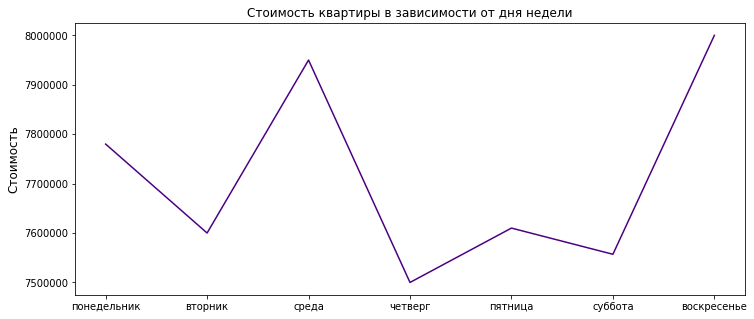

In [94]:
plt.figure(figsize=(12,5))
plt.plot( day_price_center.index, day_price_center['last_price'], color="indigo" )
plt.ylabel("Стоимость", fontsize=12)
plt.title("Стоимость квартиры в зависимости от дня недели")
plt.show()

>#### Зависимость стоимости квартиры от дня недели также разительно отличается, дешевле всего квартиры выставляются на продажу по четвергам, а по наиболее высокой цене по воскресеньям

<a id='section5'></a>

## Шаг 5. Общий вывод

___

>#### 1. На первом шаге при знакомстве с датасетом были обнаружены множественные пропуски, а также много аномалий, от которых мы в последствии успешно избавились. 
>#### 2. На втором этапе для пропущенных значений этажности и высоты потолков домов были восстановлены значения по доступным данным из датасета. Заполнены другие пропущенные значения. Изменены типы данных, обработаны выбросы и аномальные значения.
>#### 3. На третьем шаге были посчитаны и добавлены в таблицу:
    1. Цена квадратного метра;
    2. День недели, месяц и год публикации объявления;
    3. Этаж квартиры; варианты — первый, последний, другой;
    4. Соотношение жилой и общей площади, а также отношение площади кухни к общей.
>#### 4. На четвертом этапе был произведен исследовательский анализ данных и было выявлено, что:
    1. В среднем квартира продается около трех месяцев
    2. Стоимость квартиры прямопропорционально зависит от площади и количества комнат и обратно пропорциональна расстоянию до центра
    3. На первом этаже квартиры стоят дешевле
    4. Стоимость квартир с 2014 по 2017 снизилась более чем на 2,5 млн. руб.
    5. В июне квартиры продаются по самой низкой стоимости, а в апреле по самой высокой
    6. Квартира выставленная на продажу в воскресенье в среднем продается на 200 тыс. дешевле чем в пик - во вторник
    7. Самые дорогие квартиры находятся в Санкт-Петербурге и Пушкине, а самые дешевые в Выборге
    8. Граница центра - 9 километров
    9. Квартиры в центре сильно отличаются в цене, они примерно в два раза дороже. Площадь квартир больше в среднем на 15 кв.м. Чаще встречаются двух- и трехкомнатные квартиры, нежели однокомнатные. Более высокие потолки - 3 метра, для остальных квартир из датасета - 2,65. 
    10. Стоимость квартир в центре также зависит от количества комнат, от этажа (на первом - дешевле), а от удаленности цена квартиры не зависит, в отличие от квартир из всей выборки.
    11. Стоимость квартир в центре Санкт-Петербурга также упала с 2014 года.
    12. По самой дешевой цене квартиры продаются в декабре, по самой дорогой - в сентябре
    13. Квартиры, размещаемые на продажу по четвергам продаются дешевле, чем в остальные дни. Пик стоимости приходится на воскресенье